/var/folders/29/djsmqb0d08111dt3p__blcbw0000gn/T/ipykernel_2789/200811164.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x0_samples = np.random.multivariate_normal(mean_x0, cov_x0, 1000)


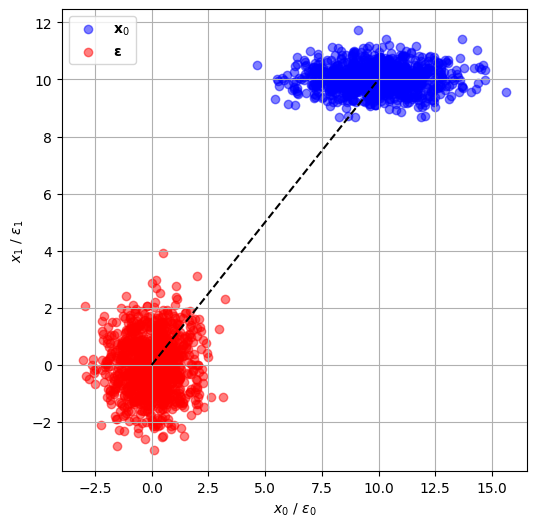

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
import os
from PIL import Image
import torch

# Set random seed for reproducibility
np.random.seed(42)

# Mean and covariance for x_0
mean_x0 = np.array([10, 10])
cov_x0 = np.array([[3.0, 0.], [0.1, 0.2]])

# Generate samples for x_0 from the multivariate normal distribution
x0_samples = np.random.multivariate_normal(mean_x0, cov_x0, 1000)

# Generate samples for epsilon from standard normal distribution
epsilon_samples = np.random.multivariate_normal([0, 0], np.eye(2), 1000)

# Create a plot for both distributions
plt.figure(figsize=(6, 6))
plt.scatter(x0_samples[:, 0], x0_samples[:, 1], alpha=0.5, label='$\mathbf{x}_0$', color='blue')
plt.scatter(epsilon_samples[:, 0], epsilon_samples[:, 1], alpha=0.5, label='$\mathbf{\epsilon}$', color='red')
plt.plot([0,10], [0,10], color='black', linestyle='--')
# Add labels and title
plt.xlabel('$x_0$ / $\epsilon_0$')
plt.ylabel('$x_1$ / $\epsilon_1$')
plt.legend()

# Display the plot
plt.grid(True)
plt.savefig("output1.png")

In [17]:
(epsilon_samples - x0_samples) / 1

array([[ -9.81474415, -10.08078362],
       [ -9.66876215, -10.98638761],
       [-12.29952571,  -9.68293103],
       ...,
       [-11.45512186, -10.44863591],
       [-12.12463978,  -9.92612486],
       [ -8.63988273,  -9.30694515]])

In [65]:
t = 0.0000001

x_t = ( 1 - (1 - 1e-5) * t ) * x0_samples + t * epsilon_samples

v = (x0_samples - x_t) / (0 - t)

In [66]:
v

array([[ -9.81465275, -10.08068425],
       [ -9.66867338, -10.98628083],
       [-12.29942166,  -9.68283207],
       ...,
       [-11.45502795, -10.44853114],
       [-12.12453931,  -9.9260288 ],
       [ -8.6397799 ,  -9.30684847]])

In [72]:
scheduler = DDPMScheduler(num_train_timesteps=1000)

In [73]:
if not os.path.exists("ddpm_gif"):
    os.makedirs("ddpm_gif")

images = []

noise = torch.randn(x0_samples.shape)
x0_samples_tensor = torch.tensor(x0_samples)

for t in range(0, 1000, 50):
    t = torch.tensor(t)
    noise_samples = scheduler.add_noise(x0_samples_tensor, noise, t)
    plt.figure(figsize=(6, 6))
    plt.scatter(epsilon_samples[:, 0], epsilon_samples[:, 1], alpha=0.5, label='$\mathbf{\epsilon}$', color='red')
    plt.scatter(noise_samples[:, 0], noise_samples[:, 1], alpha=0.5, color='blue', label=f"Step {t}")
    center_point = torch.mean(noise_samples, dim=0)
    plt.scatter(center_point[0], center_point[1], marker='x', color='green')
    plt.plot([0,10], [0,10], color='black', linestyle='--')
    plt.title(f"DDPM Diffusion Process - Step {t}")
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    plt.grid(True)
    plt.legend()
    plt.xlim([-5, 12])
    plt.ylim([-5, 12])
    plt.text(-4, -4, "By Chestnut", fontsize=13)
    file_path = f"ddpm_gif/step_{t}.png"
    plt.savefig(file_path)
    plt.close()

    images.append(Image.open(file_path))

gif_path = "ddpm_diffusion.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=100, loop=0)
